In [112]:
import pandas as pd
import geopandas as gp
import maup
import numpy as np
import os
from statistics import mean, median
import matplotlib.pyplot as plt
import descartes


In [2]:
#Load Shapefiles 
#2016 VTD File
precincts = gp.read_file("VTD2016-Shape.shp")
#2012 Congressional Districts 
districts = gp.read_file("CONGPROP2.shp")
#Block-level Shapefile from Census 
blocks = gp.read_file("tl_2017_13_tabblock10.shp")

In [3]:
precincts.columns

Index(['ID', 'AREA', 'DATA', 'POPULATION', 'DISTRICT', 'CTYSOSID',
       'PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME', 'FIPS1',
       'FIPS2', 'COUNTY_NAM', 'geometry'],
      dtype='object')

In [4]:
precincts.head()

,ID,AREA,DATA,POPULATION,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNUMBER,COUNTY,CTYNAME,FIPS1,FIPS2,COUNTY_NAM,geometry
0,6094217,1.864348,690,1013,073131,073131,131,JOURNEY COMM. CHURCH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.14546 33.57854, -82.14520 33.578..."
1,6094266,1.636596,714,3858,073064,073064,064,GRACE BAPTIST CHURCH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.16342 33.57423, -82.16364 33.574..."
2,6094297,5.598643,711,1920,073061,073061,061,GREENBRIER HIGH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.16581 33.56498, -82.16577 33.564..."
3,6094341,0.872412,713,1770,073063,073063,063,RIVERSIDE ELEMENTARY,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.13909 33.57592, -82.13914 33.575..."
4,6094377,3.783726,691,3131,073132,073132,132,WESLEY METHODIST,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.14330 33.57348, -82.14300 33.573..."


In [269]:
precincts.PRECINCT_I.unique()

array(['131', '064', '061', ..., '197', '990', '833'], dtype=object)

In [124]:
precincts.POPULATION.sum()
#same as demo data total pop & final file 

9687653

Setting porjections to EPSG: 4019

In [15]:
precincts.crs

{'init': 'epsg:4019'}

In [16]:
proj = precincts.crs


In [17]:
blocks.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [19]:
precincts = precincts.to_crs(proj)
blocks = blocks.to_crs(proj)

In [90]:
#Load election and demographic Data .csv
blocks_dmo = pd.read_csv("GA_blk_dmo.csv")
election_state = pd.read_csv("2016-precinct-state.csv",encoding='latin-1', dtype={"jurisdiction": "string"},low_memory=False)
election_pres = pd.read_csv("2016-precinct-president.csv",encoding='latin-1', dtype={"jurisdiction": "string"},low_memory=False)

Need to concat both election tables, clean, pivot, and then join to precinct shapefile

In [195]:
election_pres.columns

Index(['year', 'stage', 'special', 'state', 'state_postal', 'state_fips',
       'state_icpsr', 'county_name', 'county_fips', 'county_ansi',
       'county_lat', 'county_long', 'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes', 'candidate_opensecrets', 'candidate_wikidata',
       'candidate_party', 'candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight'],
      dtype='object')

In [196]:
election_state = election_state[election_state.state_fips == 13]

In [197]:
election_pres = election_pres[election_pres.state_fips == 13]

In [198]:
election_state.head()

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
2271134,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2271135,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2271136,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2271137,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2271138,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
election_pres.head()

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
573155,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",NaN,NaN,NaN,NaN
573156,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",NaN,NaN,NaN,NaN
573157,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",NaN,NaN,NaN,NaN
573158,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",NaN,NaN,NaN,NaN
573159,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,P60012234,"JOHNSON, JOHN FITZGERALD MR.",NaN,NaN,NaN,NaN


In [207]:
election_state.office.unique()
#'State Senate'

array(['CONSTITUTIONAL AMENDMENT #1<BR>PROVIDES GREATER FLEXIBILITY AND STATE ACCOUNTABILITY TO FIX FAILING SCHOOLS THROUGH INCREASING COMMUNITY INVOLVEMENT.',
       "CONSTITUTIONAL AMENDMENT #2<BR>AUTHORIZES PENALTIES FOR SEXUAL EXPLOITATION AND ASSESSMENTS ON ADULT ENTERTAINMENT TO FUND CHILD VICTIMS' SERVICES.",
       'CONSTITUTIONAL AMENDMENT #3<BR>REFORMS AND RE-ESTABLISHES THE JUDICIAL QUALIFICATIONS COMMISSION AND PROVIDES FOR ITS COMPOSITION, GOVERNANCE, AND POWERS.',
       'CONSTITUTIONAL AMENDMENT #4<BR>DEDICATES REVENUE FROM EXISTING TAXES ON FIREWORKS TO TRAUMA CARE, FIRE SERVICES, AND PUBLIC SAFETY.',
       'PUBLIC SERVICE COMMISSION, DISTRICT 2 - EASTERN', 'State House',
       'CLERK SUPERIOR COURT', 'State Senate', 'CLERK, SUPERIOR COURT',
       'CHIEF MAGISTRATE', 'BOE, D2', 'BOE, D4', 'BOE HOGGARDS',
       'BOE ANNA', 'BOE MILFORD', 'BOE NEWTON', 'BOE ELMODEL',
       'SUPERIOR COURT CLERK', 'BOE 4', 'BOE 1', 'BOE 2',
       'BOE 8 AT LARGE', 'BOE 6', 'BOE 5', '

In [221]:
election_state.party.unique()
#no libertarian senate candidate??

array(['republican', nan, 'democratic'], dtype=object)

In [208]:
election_state = election_state[(election_state.office=="State Senate")]

In [185]:
election_pres.office.unique()
#"US President"

array(['US President'], dtype=object)

In [209]:
election_pres = election_pres[(election_pres.office=="US President")]

In [210]:
#concat both election tables to then pivot
frames = [election_state, election_pres]
election = pd.concat(frames)

In [211]:
election.head()

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
2271182,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2271183,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2271184,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2271185,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2271234,2016,gen,False,Georgia,GA,13,44,Appling County,13001.0,349113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
election.columns

Index(['year', 'stage', 'special', 'state', 'state_postal', 'state_fips',
       'state_icpsr', 'county_name', 'county_fips', 'county_ansi',
       'county_lat', 'county_long', 'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes', 'candidate_opensecrets', 'candidate_wikidata',
       'candidate_party', 'candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight'],
      dtype='object')

In [245]:
election = election.drop(columns=['state','special','candidate_opensecrets',
                                  'candidate_wikidata','candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight','candidate','candidate_normalized','candidate',
                                  'candidate_normalized',
                                 'mode'])

KeyError: "['state' 'special' 'candidate_opensecrets' 'candidate_wikidata'\n 'candidate_last' 'candidate_first' 'candidate_middle' 'candidate_full'\n 'candidate_suffix' 'candidate_nickname' 'candidate_fec'\n 'candidate_fec_name' 'candidate_google' 'candidate_govtrack'\n 'candidate_icpsr' 'candidate_maplight'] not found in axis"

In [257]:
election.columns

Index(['year', 'stage', 'state_postal', 'state_fips', 'state_icpsr',
       'county_name', 'county_fips', 'county_ansi', 'county_lat',
       'county_long', 'jurisdiction', 'precinct', 'office', 'district',
       'writein', 'party', 'votes', 'candidate_party'],
      dtype='object')

In [265]:

pd.options.display.max_columns = None
pd.options.display.max_rows = None
election.head()


,year,stage,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,county_lat,county_long,jurisdiction,precinct,office,district,writein,party,votes,candidate_party
2271182,2016,gen,GA,13,44,Appling County,13001.0,349113.0,31.73971,-82.2901,Appling,2,State Senate,19,False,republican,353,NaN
2271183,2016,gen,GA,13,44,Appling County,13001.0,349113.0,31.73971,-82.2901,Appling,2,State Senate,19,False,republican,59,NaN
2271184,2016,gen,GA,13,44,Appling County,13001.0,349113.0,31.73971,-82.2901,Appling,2,State Senate,19,False,republican,279,NaN
2271185,2016,gen,GA,13,44,Appling County,13001.0,349113.0,31.73971,-82.2901,Appling,2,State Senate,19,False,republican,0,NaN
2271234,2016,gen,GA,13,44,Appling County,13001.0,349113.0,31.73971,-82.2901,Appling,3C,State Senate,19,False,republican,285,NaN


In [276]:
precincts.PRECINCT_I.unique()

array(['131', '064', '061', ..., '197', '990', '833'], dtype=object)

In [277]:
precincts.PRECINCT_I.nunique()

1654

In [272]:
precincts.PRECINCT_I.count()

2664

In [278]:
election.precinct.nunique()

2630

In [275]:
election.precinct.unique()

array(['2', '3C', '4B', ..., 'Sylver East', 'Sylvester', 'Warwick'],
      dtype=object)

In [273]:
election.precinct.count()

46426

In [266]:
precincts.head()

,ID,AREA,DATA,POPULATION,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNUMBER,COUNTY,CTYNAME,FIPS1,FIPS2,COUNTY_NAM,geometry
0,6094217,1.864348,690,1013,073131,073131,131,JOURNEY COMM. CHURCH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.14546 33.57854, -82.14520 33.578..."
1,6094266,1.636596,714,3858,073064,073064,064,GRACE BAPTIST CHURCH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.16342 33.57423, -82.16364 33.574..."
2,6094297,5.598643,711,1920,073061,073061,061,GREENBRIER HIGH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.16581 33.56498, -82.16577 33.564..."
3,6094341,0.872412,713,1770,073063,073063,063,RIVERSIDE ELEMENTARY,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.13909 33.57592, -82.13914 33.575..."
4,6094377,3.783726,691,3131,073132,073132,132,WESLEY METHODIST,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.14330 33.57348, -82.14300 33.573..."


Waiting on Ruth on how they cleaned election results table to join to precincts. Then the following code should work:

In [258]:
elect_16 = election.pivot_table(index = ['precinct'], columns = ['office','party'], values = ['votes'])







In [259]:
elect_16.columns = elect_16.columns.to_series().str.join(' ')

columns = elect_16.columns.values

In [260]:
print(columns)

['votes State Senate democratic' 'votes State Senate republican'
 'votes US President democratic' 'votes US President libertarian'
 'votes US President republican']


In [261]:
elect_16 = elect_16.rename(columns = {'votes State Senate democratic': 'SEN16D', 
                                      'votes State Senate republican':'SEN16R',
                                      'votes US President democratic':'PRES16D', 
                                      'votes US President libertarian':'PRES16L',
                                      'votes US President republican': 'PRES16R'})
                                      
                                      
                                      

In [262]:
elect_16 = elect_16.fillna(0)



In [263]:
elect_16.head(2)

,SEN16D,SEN16R,PRES16D,PRES16L,PRES16R
precinct,,,,,
01 Bethlehem Community Center,0.00,385.75,0.0,0.0,0.0
01 Big Creek,697.25,1983.00,0.0,0.0,0.0


Merge block-level shapefile and demographic data

In [96]:
blocks_dmo['geoid']=blocks_dmo['geoid'].astype(int)
blocks['geoid']=blocks['geoid'].astype(int)


In [97]:
blocks.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'geoid'],
      dtype='object')

In [98]:
blocks_dmo.columns

Index(['Unnamed: 0', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN ', 'NH_ASIAN',
       'NH_NHPI ', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'NAME', 'state', 'county', 'tract', 'block', 'geoid'],
      dtype='object')

In [99]:
blocks_all = pd.merge(blocks, blocks_dmo, on='geoid', how='left', indicator=True)

In [101]:
blocks_all.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'geoid',
       'Unnamed: 0', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN ', 'NH_ASIAN',
       'NH_NHPI ', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'NAME', 'state', 'county', 'tract', 'block', '_merge'],
      dtype='object')

In [107]:
blocks_all.TOTPOP.sum()
#google says 10.3 million, but this matches MGGG final file

9687653

In [103]:
blocks_all = blocks_all.drop(columns = "geoid")

In [104]:
blocks_all.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry',
       'Unnamed: 0', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN ', 'NH_ASIAN',
       'NH_NHPI ', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'NAME', 'state', 'county', 'tract', 'block', '_merge'],
      dtype='object')

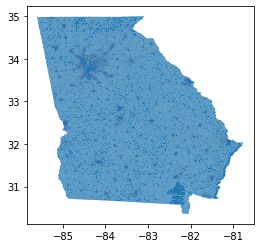

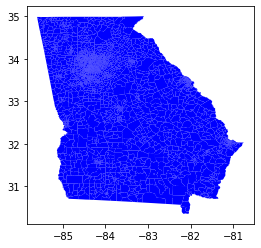

In [113]:
#blocks_all.plot()
#precincts.plot(color='blue')

In [279]:
variables = ['TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN ', 'NH_ASIAN', 'NH_NHPI ',
       'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN ',
       'H_ASIAN', 'H_NHPI ', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP',
       'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']
assignment = maup.assign(blocks_dmo, precincts, area_cutoff=0)
#error 'DataFrame' object has no attribute 'crs'


AttributeError: 'DataFrame' object has no attribute 'crs'